In [1]:
# ===============================
# VALORANT PREDICTIVE ANALYSIS NOTEBOOK
# ===============================

# Cell 1: Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import linregress

# Set plot style
sns.set_style("whitegrid")
%matplotlib inline


In [2]:
# Cell 2: Load Data
CSV_FILE = "matches.csv"

df = pd.read_csv(CSV_FILE)

# Create total engagements column
df["total_engagements"] = df["kills"] + df["deaths"] + df["assists"]

# Replace 0 deaths to avoid division by zero in KD
df["kd_ratio"] = df["kills"] / df["deaths"].replace(0, 1)

# Fill missing hs_percent
df["hs_percent"] = df["hs_percent"].fillna(0)

df.head()

,match_id,map,game_start,agent,kills,deaths,assists,score,shots_total,hs_percent,kd_ratio,total_engagements,win
0,83ef374d-d71b-465f-ad1e-3dae655cf2e5,Icebox,2025-08-13T19:54:31.335Z,Chamber,24,18,1,6277,46,32.608696,1.333333,43,0.0
1,974f835d-f1aa-49eb-8d4d-df08dec70ba1,Bind,2025-08-13T19:15:13.394Z,Chamber,16,16,1,3744,25,36.000000,1.000000,33,1.0
2,05b810fd-d8ba-4f2b-bf35-ef83c3241117,Ascent,2025-08-13T18:00:21.25Z,Reyna,21,16,5,5649,61,27.868852,1.312500,42,1.0
3,7d2e7812-8a9b-4fe4-bcf5-77b67683be93,Icebox,2025-08-07T20:38:29.558Z,Chamber,18,10,1,4934,28,35.714286,1.800000,29,1.0
4,bd4e0fac-03ad-48e9-b650-88b2477d7650,Sunset,2025-08-07T20:00:39.905Z,Reyna,13,17,4,4109,43,25.581395,0.764706,34,1.0


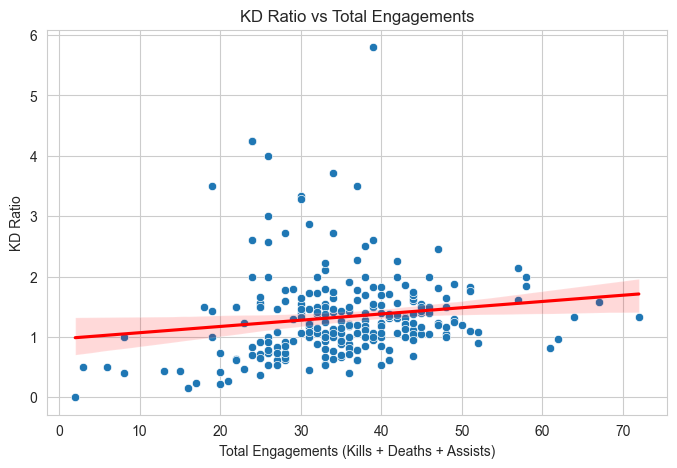

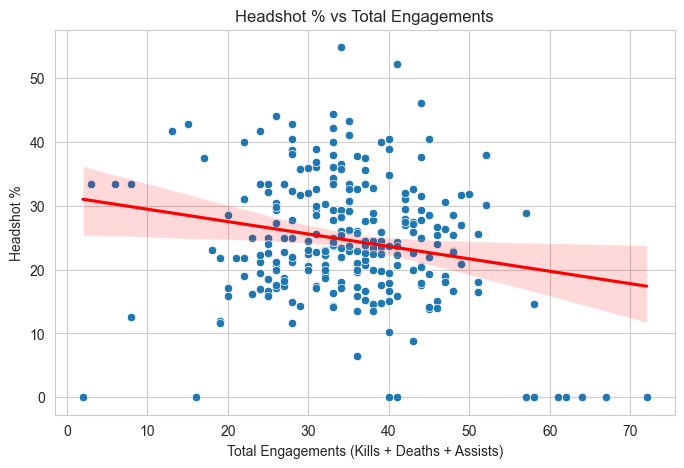

In [3]:
# Cell 3: Exploratory Data Analysis - Scatter Plots

# KD Ratio vs Total Engagements
plt.figure(figsize=(8,5))
sns.scatterplot(x="total_engagements", y="kd_ratio", data=df)
sns.regplot(x="total_engagements", y="kd_ratio", data=df, scatter=False, color="red")
plt.xlabel("Total Engagements (Kills + Deaths + Assists)")
plt.ylabel("KD Ratio")
plt.title("KD Ratio vs Total Engagements")
plt.show()

# HS% vs Total Engagements
plt.figure(figsize=(8,5))
sns.scatterplot(x="total_engagements", y="hs_percent", data=df)
sns.regplot(x="total_engagements", y="hs_percent", data=df, scatter=False, color="red")
plt.xlabel("Total Engagements (Kills + Deaths + Assists)")
plt.ylabel("Headshot %")
plt.title("Headshot % vs Total Engagements")
plt.show()

In [4]:
# Cell 4: Predictive Analysis - HS%, KD, Engagements

features = df[["hs_percent", "kd_ratio", "total_engagements"]].fillna(0)
target = df["win"].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("=== Predictive Analysis (HS%, KD, Engagements) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature importance
importance = pd.DataFrame({"feature": features.columns, "coefficient": model.coef_[0]})
importance

=== Predictive Analysis (HS%, KD, Engagements) ===
Accuracy: 0.6923076923076923

Confusion Matrix:
 [[17  8]
 [ 8 19]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.68      0.68        25
         1.0       0.70      0.70      0.70        27

    accuracy                           0.69        52
   macro avg       0.69      0.69      0.69        52
weighted avg       0.69      0.69      0.69        52



,feature,coefficient
0,hs_percent,0.002832
1,kd_ratio,2.707617
2,total_engagements,-0.040944


In [ ]:
# Cell 5: KD Win Probability Curve

# Fit logistic regression on KD only
kd_features = df[["kd_ratio"]].fillna(0)
kd_target = df["win"].fillna(0)

kd_model = LogisticRegression()
kd_model.fit(kd_features, kd_target)

# Function to calculate KD for a given win probability
def kd_for_win_prob(prob):
    return (np.log(prob/(1-prob)) - kd_model.intercept_[0]) / kd_model.coef_[0][0]

for p in [0.5, 0.6, 0.7]:
    print(f"KD needed for {int(p*100)}% win chance: {kd_for_win_prob(p):.3f}")


IndexError: invalid index to scalar variable.

In [ ]:
# Cell 6: KD vs Engagement Regression

slope, intercept, r_value, p_value, std_err = linregress(df["total_engagements"], df["kd_ratio"])
print("=== KD vs Engagement Regression ===")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"Correlation (R): {r_value:.4f}")
print(f"P-value: {p_value:.6f}")

plt.figure(figsize=(8,5))
sns.scatterplot(x="total_engagements", y="kd_ratio", data=df, alpha=0.5)
plt.plot(df["total_engagements"], intercept + slope*df["total_engagements"], color="red")
plt.xlabel("Total Engagements")
plt.ylabel("KD Ratio")
plt.title("KD Ratio vs Total Engagements")
plt.show()

In [ ]:
# Cell 7: Interactive KD Win Probability Simulator
import ipywidgets as widgets
from IPython.display import display

# Function to compute predicted win probability from KD
def predict_win_prob(kd):
    logit = kd_model.intercept_[0] + kd_model.coef_[0][0] * kd
    prob = 1 / (1 + np.exp(-logit))
    print(f"Predicted win probability for KD = {kd:.2f}: {prob*100:.2f}%")

# Slider widget
kd_slider = widgets.FloatSlider(
    value=1.0,
    min=0.0,
    max=df["kd_ratio"].max()+1,
    step=0.01,
    description='KD:',
    continuous_update=False
)

# Interactive display
widgets.interact(predict_win_prob, kd=kd_slider)